In [1]:
# WARNING: This deletes EVERYTHING in your output folder (checkpoints, logs, csvs)
# !rm -rf /kaggle/working/*

In [ ]:
# !pip install -q transformers datasets scikit-learn seaborn matplotlib evaluate

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datasets import load_dataset, Dataset
from transformers import (
    AutoTokenizer, 
    AutoModelForSequenceClassification, 
    Trainer, 
    TrainingArguments,
    DataCollatorWithPadding,
    EarlyStoppingCallback
)
import seaborn as sns
from sklearn.metrics import f1_score, accuracy_score, classification_report
import torch.nn as nn

# --- Configuration ---
MODEL_NAME = "distilroberta-base"
# https://huggingface.co/datasets/cirimus/super-emotion
DATASET_NAME = "cirimus/super-emotion"
BATCH_SIZE = 8
MAX_LENGTH = 512
LEARNING_RATE = 2e-5 
EPOCHS = 15 

# Define Labels
LABELS = ["anger", "fear", "joy", "love", "neutral", "sadness", "surprise"]
id2label = {idx: label for idx, label in enumerate(LABELS)}
label2id = {label: idx for idx, label in enumerate(LABELS)}
num_labels = len(LABELS)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

2026-01-13 09:23:59.102901: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1768296239.440570      24 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1768296239.544064      24 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1768296240.370619      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768296240.370661      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768296240.370663      24 computation_placer.cc:177] computation placer alr

Device: cuda


Loading dataset...


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/28.1M [00:00<?, ?B/s]

data/validation-00000-of-00001.parquet:   0%|          | 0.00/3.50M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/3.76M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/439361 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/54835 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/58625 [00:00<?, ? examples/s]


Original Class Distribution:
primary_label
joy         132876
sadness     110029
anger        59402
fear         48042
love         44785
neutral      24893
surprise     19334
Name: count, dtype: int64


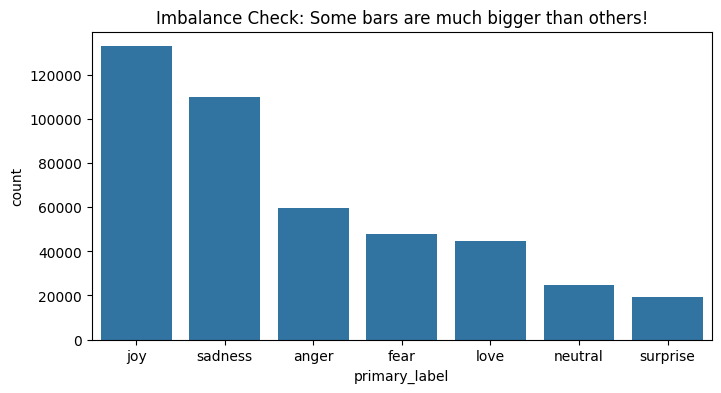

In [3]:
print("Loading dataset...")
dataset = load_dataset(DATASET_NAME)
train_df = dataset['train'].to_pandas()


def ensure_list(x):
    if isinstance(x, np.ndarray): return x.tolist()
    if isinstance(x, list): return x
    return [x]

train_df['labels'] = train_df['labels'].apply(ensure_list)


train_df['primary_label'] = train_df['labels'].apply(lambda x: LABELS[x[0]] if len(x) > 0 and x[0] < len(LABELS) else "unknown")

# --- Exploration ---
# We check how many samples we have for each emotion.
print("\nOriginal Class Distribution:")
print(train_df['primary_label'].value_counts())

# Visualize it so you can see the imbalance
plt.figure(figsize=(8, 4))
sns.countplot(x='primary_label', data=train_df, order=train_df['primary_label'].value_counts().index)
plt.title("Imbalance Check: Some bars are much bigger than others!")
plt.show()

In [4]:
# let's automatically pick the median size of all classes to balance them out
counts = train_df['primary_label'].value_counts()
target_size = int(counts.median()) 

print(f"Balancing all classes to target size: {target_size}")

balanced_dfs = []

for label in LABELS:
    # Get all rows for this specific emotion
    df_label = train_df[train_df['primary_label'] == label]
    
    if len(df_label) >= target_size:
        # If too big, randomly sample down (Undersample)
        balanced_dfs.append(df_label.sample(target_size, random_state=42))
    else:
        # If too small, sample with replacement (Oversample/Duplicate)
        # This repeats some examples to fill the gap
        balanced_dfs.append(df_label.sample(target_size, replace=True, random_state=42))

# Combine them all
balanced_train_df = pd.concat(balanced_dfs).sample(frac=1, random_state=42).reset_index(drop=True)

# Convert back to Dataset
train_dataset = Dataset.from_pandas(balanced_train_df)
val_dataset = dataset['validation']
test_dataset = dataset['test']

print("\nNew Class Distribution:")
print(balanced_train_df['primary_label'].value_counts())

Balancing all classes to target size: 48042

New Class Distribution:
primary_label
neutral     48042
joy         48042
anger       48042
love        48042
surprise    48042
sadness     48042
fear        48042
Name: count, dtype: int64


In [5]:
# --- Tokenize ---
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
train_dataset = Dataset.from_pandas(balanced_train_df)
val_dataset = dataset['validation']
test_dataset = dataset['test']

def preprocess_function(examples):
    tokenized = tokenizer(examples["text"], truncation=True, max_length=MAX_LENGTH, padding=False)
    # Convert labels to multi-hot vectors (floats)
    batch_labels = []
    for labels_entry in examples["labels"]:
        vector = [0.0] * num_labels
        entry = labels_entry if isinstance(labels_entry, list) else [labels_entry]
        for label_id in entry:
            if label_id < num_labels:
                vector[label_id] = 1.0
        batch_labels.append(vector)
    tokenized["labels"] = batch_labels
    return tokenized

print("Tokenizing data...")
train_tokenized = train_dataset.map(preprocess_function, batched=True)
val_tokenized = val_dataset.map(preprocess_function, batched=True)
test_tokenized = test_dataset.map(preprocess_function, batched=True)

# Set format for PyTorch
for d in [train_tokenized, val_tokenized, test_tokenized]:
    d.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Tokenizing data...


Map:   0%|          | 0/336294 [00:00<?, ? examples/s]

Map:   0%|          | 0/54835 [00:00<?, ? examples/s]

Map:   0%|          | 0/58625 [00:00<?, ? examples/s]

In [6]:
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME, 
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id,
    problem_type="multi_label_classification"
).to(device)

model.safetensors:   0%|          | 0.00/331M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    probs = 1 / (1 + np.exp(-logits))
    predictions = (probs > 0.5).astype(int)
    
    f1_micro = f1_score(labels, predictions, average='micro')
    f1_macro = f1_score(labels, predictions, average='macro')
    acc = accuracy_score(labels, predictions)
    
    return {"f1_micro": f1_micro, "f1_macro": f1_macro, "accuracy": acc}

In [8]:
# small helper to force labels to be Floats
def float_label_collator(features):
    # Use the tokenizer to pad the batch as usual
    batch = tokenizer.pad(features, padding=True, return_tensors="pt")
    # Cast labels to float (Fixes the RuntimeError)
    batch["labels"] = batch["labels"].float()
    return batch

training_args = TrainingArguments(
    output_dir="./emotion_checkpoint_model",
    learning_rate=LEARNING_RATE,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=EPOCHS,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True, # Crucial: Loads the best checkpoint, not the last one
    metric_for_best_model="loss",
    save_total_limit=2,
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_tokenized,
    eval_dataset=val_tokenized,
    processing_class=tokenizer, 
    data_collator=float_label_collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

print("Starting Training...")
trainer.train()

You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Starting Training...


Epoch,Training Loss,Validation Loss,F1 Micro,F1 Macro,Accuracy
1,0.104400,0.096049,0.856437,0.806995,0.831586
2,0.093900,0.102724,0.855710,0.798329,0.829306
3,0.075400,0.112088,0.852636,0.792968,0.824820
4,0.065200,0.117817,0.854308,0.797626,0.836965


TrainOutput(global_step=168148, training_loss=0.09139471289790357, metrics={'train_runtime': 5104.6683, 'train_samples_per_second': 988.195, 'train_steps_per_second': 123.525, 'total_flos': 1.3707354294127884e+16, 'train_loss': 0.09139471289790357, 'epoch': 4.0})

In [9]:
print("Evaluating on Test Set...")
test_results = trainer.evaluate(test_tokenized)
print(test_results)

# Generate Detailed Report
preds = trainer.predict(test_tokenized)
y_pred = (1 / (1 + np.exp(-preds.predictions)) > 0.5).astype(int)
y_true = np.array(test_tokenized["labels"])

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=LABELS, zero_division=0))

Evaluating on Test Set...


{'eval_loss': 0.11225854605436325, 'eval_f1_micro': 0.838264909627228, 'eval_f1_macro': 0.7931281467991281, 'eval_accuracy': 0.8039402985074627, 'eval_runtime': 67.5785, 'eval_samples_per_second': 867.51, 'eval_steps_per_second': 108.452, 'epoch': 4.0}

Classification Report:
              precision    recall  f1-score   support

       anger       0.86      0.85      0.85      8705
        fear       0.88      0.78      0.83      6474
         joy       0.98      0.81      0.89     18484
        love       0.70      0.87      0.78      6157
     neutral       0.55      0.72      0.63      3925
     sadness       0.99      0.85      0.91     14853
    surprise       0.60      0.77      0.67      2660

   micro avg       0.86      0.82      0.84     61258
   macro avg       0.79      0.80      0.79     61258
weighted avg       0.88      0.82      0.84     61258
 samples avg       0.83      0.83      0.83     61258



In [10]:
# Get raw predictions (logits) again
raw_preds = trainer.predict(test_tokenized)
logits = raw_preds.predictions

# Sigmoid to get probabilities (0 to 1)
probs = 1 / (1 + np.exp(-logits))

# --- THE TWEAK ---
# Instead of 0.5, let's try 0.8 (80% confidence required)
THRESHOLD = 0.80 

y_pred_new = (probs > THRESHOLD).astype(int)
y_true = np.array(test_tokenized["labels"])

print(f"--- Classification Report with Threshold {THRESHOLD} ---")
print(classification_report(y_true, y_pred_new, target_names=LABELS, zero_division=0))

--- Classification Report with Threshold 0.8 ---
              precision    recall  f1-score   support

       anger       0.95      0.76      0.84      8705
        fear       0.97      0.68      0.80      6474
         joy       0.99      0.79      0.88     18484
        love       0.88      0.63      0.74      6157
     neutral       0.70      0.46      0.55      3925
     sadness       1.00      0.83      0.90     14853
    surprise       0.75      0.56      0.64      2660

   micro avg       0.95      0.74      0.83     61258
   macro avg       0.89      0.67      0.77     61258
weighted avg       0.94      0.74      0.83     61258
 samples avg       0.76      0.75      0.75     61258



In [11]:
def optimize_threshold(predictions, labels, step=0.01):
    """
    Loops through thresholds from 0.1 to 0.9 to find the best F1 score.
    """
    # Convert logits to probabilities
    probs = 1 / (1 + np.exp(-predictions))
    
    best_threshold = 0.5
    best_f1 = 0.0
    
    # Iterate through thresholds
    print("Scanning thresholds...")
    for threshold in np.arange(0.1, 0.95, step):
        # Apply threshold
        y_pred_temp = (probs > threshold).astype(int)
        
        # Calculate score (using 'micro' usually best for overall performance)
        current_f1 = f1_score(labels, y_pred_temp, average='macro')
        
        if current_f1 > best_f1:
            best_f1 = current_f1
            best_threshold = threshold

    print(f"\n✅ Best Threshold Found: {best_threshold:.2f}")
    print(f"✅ Best F1-Micro Score: {best_f1:.4f}")
    return best_threshold

# --- Usage ---
# Get raw predictions (logits) from the test set
raw_preds = trainer.predict(test_tokenized)

# Run the optimization
optimal_thresh = optimize_threshold(raw_preds.predictions, raw_preds.label_ids)

# --- Apply the Best Threshold ---
probs = 1 / (1 + np.exp(-raw_preds.predictions))
final_preds = (probs > optimal_thresh).astype(int)

print(f"\n--- Final Report (Threshold: {optimal_thresh:.2f}) ---")
print(classification_report(raw_preds.label_ids, final_preds, target_names=LABELS, zero_division=0))

Scanning thresholds...

✅ Best Threshold Found: 0.56
✅ Best F1-Micro Score: 0.7946

--- Final Report (Threshold: 0.56) ---
              precision    recall  f1-score   support

       anger       0.87      0.83      0.85      8705
        fear       0.89      0.77      0.83      6474
         joy       0.98      0.81      0.89     18484
        love       0.71      0.86      0.78      6157
     neutral       0.58      0.68      0.63      3925
     sadness       0.99      0.84      0.91     14853
    surprise       0.62      0.76      0.68      2660

   micro avg       0.87      0.81      0.84     61258
   macro avg       0.81      0.79      0.79     61258
weighted avg       0.89      0.81      0.84     61258
 samples avg       0.83      0.82      0.82     61258



<Figure size 1000x800 with 0 Axes>

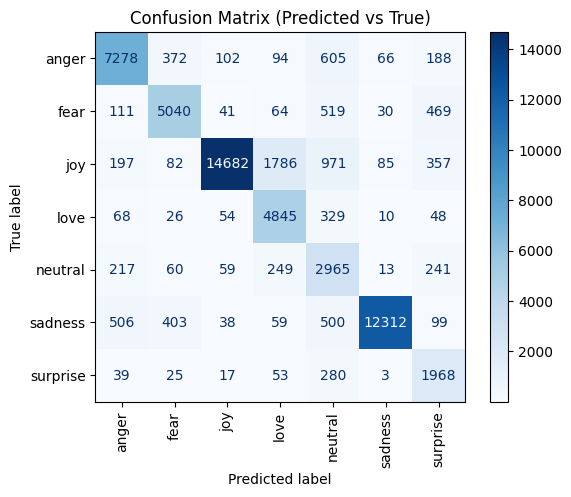

In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

# Get raw predictions (Logits)
raw_outputs = trainer.predict(test_tokenized)
logits = raw_outputs.predictions
true_labels_one_hot = raw_outputs.label_ids

# Convert to Indices using argmax (Pick the highest number)
# axis=1 means "look across the columns for each row"
y_pred_indices = np.argmax(logits, axis=1)
y_true_indices = np.argmax(true_labels_one_hot, axis=1)

# Create the Matrix
cm = confusion_matrix(y_true_indices, y_pred_indices)

# Plot
plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=LABELS)
disp.plot(cmap='Blues', values_format='d', xticks_rotation='vertical')
plt.title("Confusion Matrix (Predicted vs True)")
plt.show()

In [13]:
text = "I guess it's okay, but I was expecting more."
inputs = tokenizer(text, return_tensors="pt").to(device)
logits = model(**inputs).logits
probs = torch.sigmoid(logits)
print({label: prob.item() for label, prob in zip(LABELS, probs[0])})

{'anger': 0.026410095393657684, 'fear': 0.007167028728872538, 'joy': 0.07427581399679184, 'love': 0.5552206635475159, 'neutral': 0.37593138217926025, 'sadness': 0.0073019410483539104, 'surprise': 0.04081752896308899}


In [14]:
import shutil
import os
from IPython.display import FileLink
# save
trainer.save_model("./emotion_final_model")
tokenizer.save_pretrained("./emotion_final_model")


# Define folder names
model_folder = "./emotion_final_model" # This matches the trainer.save_model() path
output_filename = "emotion_model"

# Compress the folder
print(f"Zipping model from {model_folder}...")
shutil.make_archive(output_filename, 'zip', model_folder)

# Create Download Link
print(f"✅ Ready! Click below to download:")
FileLink(f'{output_filename}.zip')

Zipping model from ./emotion_final_model...
✅ Ready! Click below to download:


/kaggle/working/emotion_model.zip